# Clustering Handwritten Letters Using Unsupervised Learning

## Introduction

In this notebook, we apply unsupervised learning techniques to the EMNIST Letters dataset, which consists of grayscale images of handwritten English letters. The workflow includes data preprocessing, dimensionality reduction using Principal Component Analysis (PCA), and clustering using the K-Means algorithm. Although the dataset contains labeled classes, these labels are not used during training and are only referenced for evaluation purposes.

The goal of this notebook is to demonstrate how unsupervised methods can group visually similar handwritten letters and reveal meaningful patterns in image data.

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.metrics import normalized_mutual_info_score

import tensorflow_datasets as tfds
import tensorflow as tf

## Loading EMNIST Letters Dataset

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    "emnist/letters",
    split=["train", "test"],
    as_supervised=True, # return image, label
    with_info=True
)

In [5]:
num_train = ds_info.splits["train"].num_examples 
num_test = ds_info.splits["test"].num_examples

print(f"The number of samples in the train set is: {num_train:,}")
print(f"The number of samples in the test set is: {num_test:,}")

The number of samples in the train set is: 88,800
The number of samples in the test set is: 14,800


## Preprocess Dataset

In [7]:
def preprocess(image, label):
    image = tf.cast(image, tf.uint8)
    label = label - 1 # convert 1-26 -> 0-25
    return image, label

In [9]:
ds_all = ds_train.concatenate(ds_test)

ds_all = ds_all.map(preprocess)

To convert TFDS to numpy, we must loop through them as TFDS are iterators.

In [11]:
# Initialize empty lists to store training and testing dataset
images, labels = [], []

# Convert TensorFlow dataset to NumPy arrays and collect images and labels
for image, label in tfds.as_numpy(ds_all):
    images.append(image)
    labels.append(label)

In [13]:
X, y = np.array(images), np.array(labels)

X = X.squeeze(-1)
X = np.rot90(X, k=1, axes=(1,2)) # rotate images by 90 degrees to correct orientation
X = np.fliplr(X) # Flip training images horizontally

In [15]:
X.shape, y.shape

((103600, 28, 28), (103600,))

Let's check unique classes/labels in our target variable.

In [17]:
np.unique(y)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25], dtype=int64)

Let's check one image from the dataset

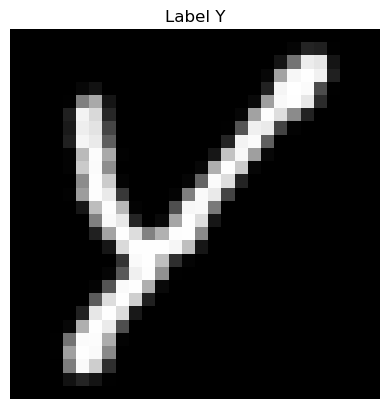

In [19]:
for i in range(1):
    plt.imshow(X[i].squeeze(), cmap='gray')
    plt.title(f"Label {chr(ord("A")+y[i])}")
    plt.axis("off")
    plt.show()

Flattening and normalizing images/inputs

In [21]:
X_flat = X.reshape(X.shape[0], -1) / 255.0

X_flat.shape

(103600, 784)

## Unsupervised Learning

Let's define helper functions here.

In [23]:
def plot_cluster_real_images(cluster_centers, X, y):
    fig, axes = plt.subplots(2, 13, figsize=(15, 3))
    
    # Plot each cluster center as an image
    for i, ax in enumerate(axes.flat):
        ax.imshow(cluster_centers[i], cmap='gray')
        ax.set_title(f"Cluster {i}")
        ax.axis("off")
        
    plt.suptitle("K-Means Cluster Centers for EMNIST Letters", fontsize=14)
    plt.tight_layout()
    plt.show()
    
    fig, axes = plt.subplots(2, 13, figsize=(15, 3))
    for i, ax in enumerate(axes.flat):
        idx = np.where(y == i)[0][0]  # first occurrence
        ax.imshow(X[idx], cmap="gray")
        ax.set_title(chr(y[idx] + ord("A")))  # map label → letter
        ax.axis("off")
        
    plt.suptitle("Sample Real Images from EMNIST Letters Dataset", fontsize=14)
    plt.tight_layout()
    plt.show()

In [25]:
def calculate_cluster_purity(cluster_labels, unique_labels, y):
    cluster_info = []
    
    for cluster_id in unique_labels:
        indices = np.where(cluster_labels == cluster_id)[0]
        
        # getting true labels for those indices
        true_labels = y[indices]
        
        # find unique labels and their counts
        unique_l, counts = np.unique(true_labels, return_counts=True)
        
        # Find the label with the maximum count
        max_id = np.argmax(counts)
        dominant_label = unique_l[max_id]
        dominant_letter = chr(dominant_label + ord("A"))
        count = counts[max_id]
        
        # Percentage of dominant label
        percentage = count / len(indices) * 100
        
        # Store the results
        cluster_info.append(
            {"cluster": cluster_id, "dominant_label": dominant_label, "dominant_letter": dominant_letter, "purity": percentage}
        )
        
        # Print the result
        print(f"Cluster {cluster_id} \n Dominant Label: {dominant_label} ({dominant_letter}), Purity: {percentage:.2f}")
        print(100*"*")
    
    return cluster_info

#### K-Means

In [27]:
kmeans = KMeans(n_clusters=26, random_state=42)
kmeans.fit(X_flat)

,n_clusters,26
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


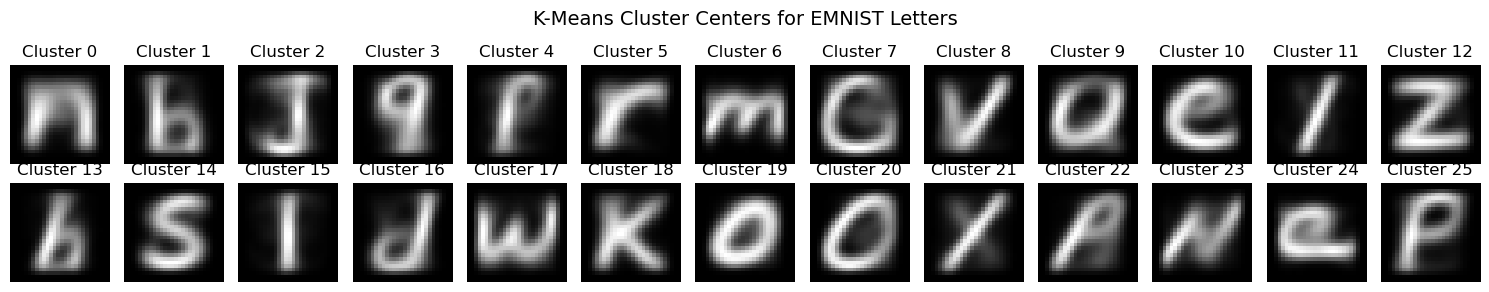

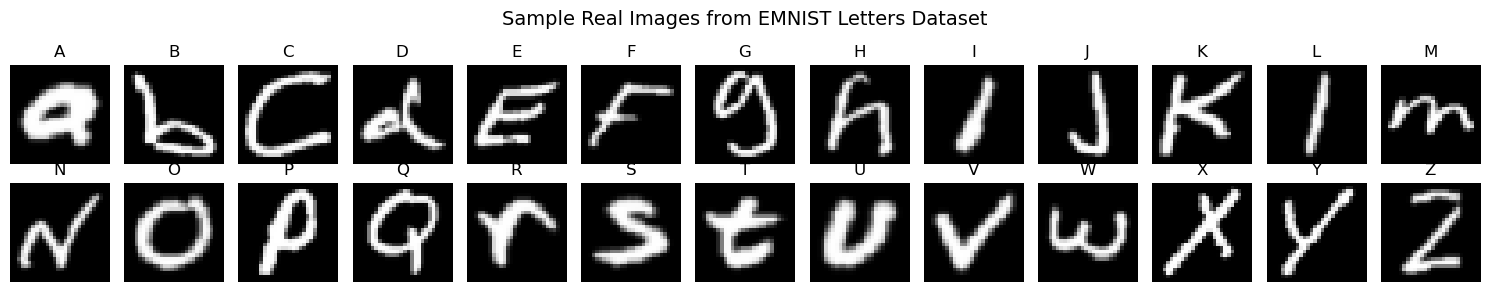

In [29]:
# Get the cluster centers and reshape each to 28x28 images
cluster_centers = kmeans.cluster_centers_.reshape(-1, 28, 28)  # reshape back to 28x28

plot_cluster_real_images(cluster_centers, X, y)

By plotting the K-Means cluster centers (which are the averages of all the images assigned to each cluster), we can see that each cluster represents a unique letter, indicating that K-Means is effectively clustering and capturing the shape of letters. However, K-Means may fail to correctly group letters whose lowercase forms are drastically different from their uppercase versions.

In [31]:
labels = kmeans.labels_
unique_labels = np.unique(labels)

cluster_info = calculate_cluster_purity(labels, unique_labels, y)

Cluster 0 
 Dominant Label: 13 (N), Purity: 52.83
****************************************************************************************************
Cluster 1 
 Dominant Label: 7 (H), Purity: 31.25
****************************************************************************************************
Cluster 2 
 Dominant Label: 9 (J), Purity: 40.94
****************************************************************************************************
Cluster 3 
 Dominant Label: 16 (Q), Purity: 32.77
****************************************************************************************************
Cluster 4 
 Dominant Label: 5 (F), Purity: 26.64
****************************************************************************************************
Cluster 5 
 Dominant Label: 17 (R), Purity: 55.27
****************************************************************************************************
Cluster 6 
 Dominant Label: 12 (M), Purity: 79.41
***********************************************

In [33]:
# extract data for plotting
clusters = [info["cluster"] for info in cluster_info]
purities = [info["purity"] for info in cluster_info]
letters = [info["dominant_letter"] for info in cluster_info]

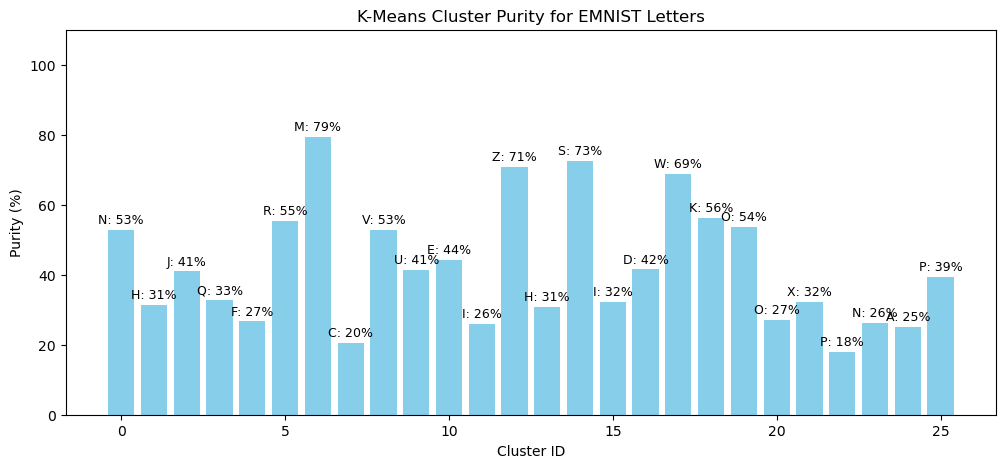

In [35]:
plt.figure(figsize=(12, 5))
bars = plt.bar(clusters, purities, color='skyblue')

for bar, letter, purity in zip(bars, letters, purities):
    plt.text(bar.get_x()+bar.get_width()/2, bar.get_height()+1, letter+f": {purity:.0f}%", ha='center', va='bottom', fontsize=9)

plt.xlabel("Cluster ID")
plt.ylabel("Purity (%)")
plt.title("K-Means Cluster Purity for EMNIST Letters")
plt.ylim(0, 110)
plt.show()

* From the plot above, we can observe that letters S, M, Z and W the highest purities in the range of 70%. It indicates that they have distinctive shapes that K-Means can easily single out. The fact is that these shapes do not change very much when written in lower or upper case formats.
* Many clusters are in the range of 20% to 40% which indicates that K-Means is often grouping multiple letters into a single cluster.

Let's compute overall purity of clusters using the below equation

The **overall purity** is a measure of how “clean” the clusters are with respect to the true labels. It is defined as:

$
\text{Overall Purity} = \frac{\sum_{c=1}^{K} p_c \cdot n_c}{N}
$

Where:

* $p_c$ = purity of cluster $c$  
  (fraction of points in cluster $c$ with the dominant true label)

* $n_c$ = number of points in cluster $c$

* $N = \sum_{c=1}^{K} n_c$ = total number of points in all clusters

---

We will also compute Normalized Mutual Information (NMI).

In [37]:
overall_purity = sum(p * np.sum(labels == c) for p, c in zip(purities, unique_labels)) / len(labels) / 100
nmi = normalized_mutual_info_score(y, labels)

print(f"Overall purity: {overall_purity:.4f}, Normalized Mutual Information (NMI): {nmi:.4f}")

Overall purity: 0.4053, Normalized Mutual Information (NMI): 0.3951


#### PCA __->__ K-Means

Let's reduce features by using PCA and then applying K-Means to observe if we can imporve overall purity and NMI scores.

In [39]:
pipeline = Pipeline([
    ("pca", PCA(n_components=2, random_state=42)),
    ("kmeans", KMeans(n_clusters=26, random_state=42))
])

# fit the pipeline on the training dataset
pipeline.fit(X_flat)

,steps,"[('pca', ...), ('kmeans', ...)]"
,transform_input,None
,memory,None
,verbose,False
,n_components,2
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10


In [41]:
pipeline.named_steps["kmeans"].cluster_centers_.shape

(26, 2)

After applying PCA with 2 components


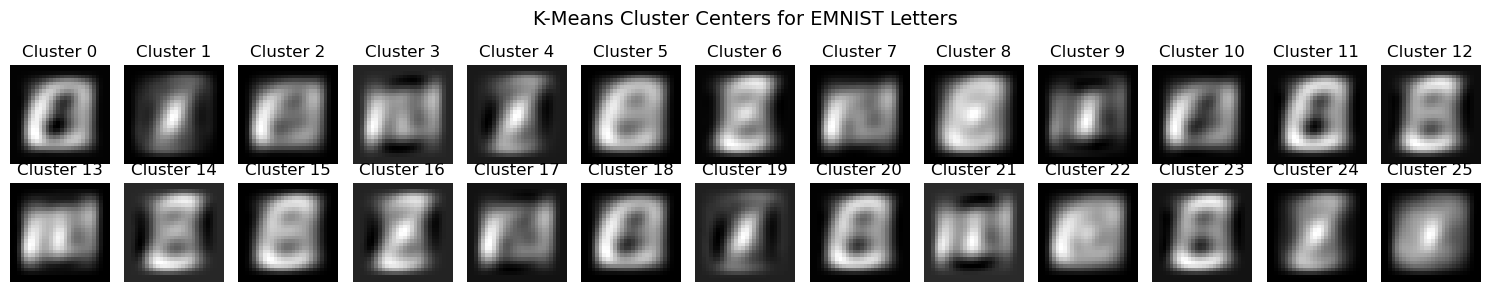

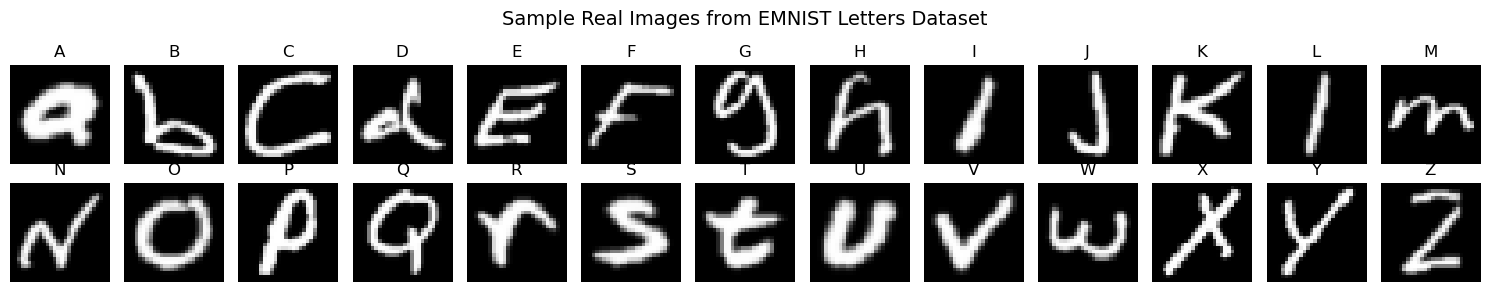

In [43]:
# Get the cluster centers and reshape each to 28x28 images
centers_pca = pipeline.named_steps["kmeans"].cluster_centers_
centers_pixels = pipeline.named_steps["pca"].inverse_transform(centers_pca)
cluster_centers = centers_pixels.reshape(-1, 28, 28)

print("After applying PCA with 2 components")
plot_cluster_real_images(cluster_centers, X, y)

We can observe with 2 PCA components, the cluster centroids are extremely blurry and faded and letters are not easily recognizable. In fact, most clusters look the same.
We can conclude that we have lost too much information by applying 2 PCA components.

In [45]:
labels = pipeline.named_steps["kmeans"].labels_
unique_labels = np.unique(labels)

cluster_info = calculate_cluster_purity(labels, unique_labels, y)

Cluster 0 
 Dominant Label: 14 (O), Purity: 53.25
****************************************************************************************************
Cluster 1 
 Dominant Label: 19 (T), Purity: 18.32
****************************************************************************************************
Cluster 2 
 Dominant Label: 17 (R), Purity: 13.42
****************************************************************************************************
Cluster 3 
 Dominant Label: 12 (M), Purity: 43.68
****************************************************************************************************
Cluster 4 
 Dominant Label: 24 (Y), Purity: 14.50
****************************************************************************************************
Cluster 5 
 Dominant Label: 16 (Q), Purity: 9.83
****************************************************************************************************
Cluster 6 
 Dominant Label: 1 (B), Purity: 10.23
**********************************************

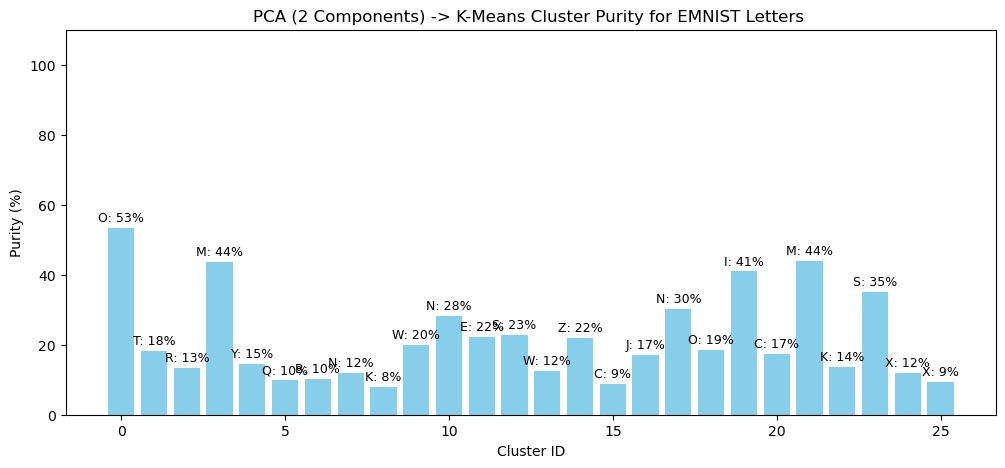

In [47]:
clusters = [info["cluster"] for info in cluster_info]
purities = [info["purity"] for info in cluster_info]
letters = [info["dominant_letter"] for info in cluster_info]

plt.figure(figsize=(12, 5))
bars = plt.bar(clusters, purities, color='skyblue')

for bar, letter, purity in zip(bars, letters, purities):
    plt.text(bar.get_x()+bar.get_width()/2, bar.get_height()+1, letter+f": {purity:.0f}%", ha='center', va='bottom', fontsize=9)

plt.xlabel("Cluster ID")
plt.ylabel("Purity (%)")
plt.title("PCA (2 Components) -> K-Means Cluster Purity for EMNIST Letters ")
plt.ylim(0, 110)
plt.show()

In [49]:
overall_purity = sum(p * np.sum(labels == c) for p, c in zip(purities, unique_labels)) / len(labels) / 100
nmi = normalized_mutual_info_score(y, labels)

print(f"Overall purity: {overall_purity:.4f}, Normalized Mutual Information (NMI): {nmi:.4f}")

Overall purity: 0.1944, Normalized Mutual Information (NMI): 0.2114


Based on the purity bar chart and overall purity and NMI results, we observe a drastic reduction in model's ability to discriminate  different letters and create a well-separated clusters that are highly dominant by a single letter.

#### Tuning the The n_components for PCA

In [51]:
pca_components = [2, 10, 50, 100, 150, 200, 300, 400, 500, 600, 700, X_flat.shape[1]]

nmi_scores = []

for n in pca_components:
    pipeline = Pipeline([
        ("pca", PCA(n_components=n, random_state=42)),
        ("kmeans", KMeans(n_clusters=26, random_state=42))
    ])
    
    # fit the pipeline on the training dataset
    pipeline.fit(X_flat)
    
    labels = pipeline.named_steps["kmeans"].labels_
    
    # Compute NMI
    nmi = normalized_mutual_info_score(y, labels)
    nmi_scores.append(nmi)

    print(f"PCA components: {n:3d} | NMI: {nmi:.4f}")

PCA components:   2 | NMI: 0.2114
PCA components:  10 | NMI: 0.3567
PCA components:  50 | NMI: 0.3987
PCA components: 100 | NMI: 0.3998
PCA components: 150 | NMI: 0.3972
PCA components: 200 | NMI: 0.3866
PCA components: 300 | NMI: 0.3806
PCA components: 400 | NMI: 0.3956
PCA components: 500 | NMI: 0.3959
PCA components: 600 | NMI: 0.3943
PCA components: 700 | NMI: 0.3951
PCA components: 784 | NMI: 0.3951


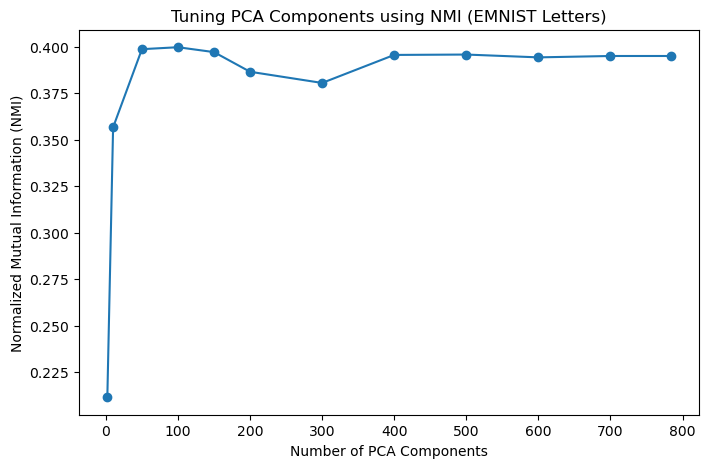

In [53]:
plt.figure(figsize=(8, 5))
plt.plot(pca_components, nmi_scores, marker='o')
plt.xlabel("Number of PCA Components")
plt.ylabel("Normalized Mutual Information (NMI)")
plt.title("Tuning PCA Components using NMI (EMNIST Letters)")
plt.show()

In [55]:
best_n = pca_components[np.argmax(nmi_scores)]
best_nmi = max(nmi_scores)

print(f"Best Number of PCA components: {best_n}")
print(f"Highest NMI score: {best_nmi:.4f}")

Best Number of PCA components: 100
Highest NMI score: 0.3998


* The graph shows that we can apply PCA to reduce features to 100 and get a better score than using all the features in the flat input.
* One hundred PCA components capture all the relevant information for the K-Means algorithm to cluster the EMNIST letters.
* The maximum NMI score is about 0.4 which is moderate performance and indicates that other strategies, alternative unsupervised models should be explored to improve the NMI score.